Lets pretend I'm a HVAC repair company looking for clients to offer my services. I'd like to target my effort on customers that are most likely to use my services. I have access to aerial imagery of the roofs of houses in a city. I'd like to use this imagery to identify houses that have HVAC units on the roof that may be leaking. I have a set of 150 images labeled via spreadsheet in the following manner: 

'row_number' Images are numebred from 1 to 150  
'image_id' - a unique identifier for each image, ending ing in .jpeg, referencing a file  
'address' - The address of the house in the image  
'ac_present' - Whether or not an air conditioner is present on the roof of the house (Yes or No), followed by the number of air conditioners present in '()'  
'ac_leaking' - Whether or not the air conditioner is leaking (Yes, No or Unknown)  
'ac_discolored' - Whether or not the roof around any AC unit is discolored (Black, White, No, Unknown). Also may be both black and white, comma separated: "black, white" OR "white, black"  
'comments' - Any additional comments about the image from the labeler(s)  

In the images, the target house is bounded by an orange square.  

This will serve as my ground truth data. I'd like to build a model that can predict whether or not an air conditioner is leaking based on the aerial imagery of the roof of a house.

Step 1: Preprocessing the data : Load the data labels spreadsheet from the folder /data/labels/. The optional "number of air conditioners part in "()" should be split off and moved to a new column called num_ac, with all nulls set to 0.  Load in the images listed in image_id from the folder /data/images/ac_150_images/ in order to crop them around the orange bounding box. Output the images to a folder called 'ac_150_images_cropped'. The file names should be the 'image_id' from the spreadsheet, but with the .jpeg extension replaced with _cropped.jpeg. For example, an image with 'image_id' 56E8920C-C46B-4CC9-96CC-178AE00230D3.jpeg should be output as 56E8920C-C46B-4CC9-96CC-178AE00230D3_cropped.jpeg.



Step 2: Building the model : The model should be able to predict whether or not an air conditioner is leaking based on the aerial imagery of the roof of a house. Priority 1 is class prediction of whether or not an air conditioner is present. Priority 2 is class prediction of whether or not an air conditioner is leaking. Priority 3 is the color of discolored air conditioners. The model could be trained from scratch, fine-tuned from a pre-trained model, use a pre-trained model as a feature extractor, or just be a model off-the-shelf.  

Step 3: Model Evaluation : The model should be split into training, testing and validation sets. Hyperparameters may be tuned on the testing set. The model should be evaluated on the validation set. The model should account for class imbalance by weighting toward recall of minority classes.

The model should be evaluated using the following metrics:
- F1 Score (the loss function)
- Accuracy
- Precision
- Recall
- ROC AUC
- Confusion Matrix
- Classification Report
- Precision-Recall Curve
- ROC Curve
- Loss Curve

For this problem ...


**For this problem**, I'd recommend using a Convolutional Neural Network (CNN) to classify the images. CNNs are particularly well-suited for image classification tasks. You can use a pre-trained model as a feature extractor, or train a model from scratch. You can use any framework you like, but I'd recommend using **PyTorch**. You can use any additional libraries you like, but I'd recommend using scikit-learn for evaluation metrics.

**Given that we have 150 labeled images** and we are looking to classify the images into one of the following categories:
- Air Conditioner Present
- Air Conditioner Leaking
- **Color of Leaking when Leaking is Present**

This is a multi-class classification problem. We can use a CNN model to classify the images. 

We will be using a pre-trained model as a feature extractor. We will use the MobileNetV2 model, which is a small, low-latency model optimized for mobile devices. We will remove the top layer of the model, add a global average pooling layer, and add a dense layer with a softmax activation function to output the class probabilities.

We will use the following evaluation metrics:
- F1 Score (the loss function)
- Accuracy
- Precision
- Recall
- ROC AUC
- Confusion Matrix
- Classification Report
- Precision-Recall Curve
- ROC Curve
- Loss Curve

We will split the data into training, testing, and validation sets. We will tune hyperparameters on the testing set and evaluate the model on the validation set. We will account for class imbalance by weighting toward recall of minority classes.

Let's get started!


In [1]:
#**I need to install all the packages in this notebook**, so I will install them all at once
# Path: image_classification.ipynb
!pip install opencv-python
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install seaborn
!pip install scikit-learn
!pip install pandas



In [2]:
# Path: image_classification.ipynb
# Load the necessary libraries
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import random


In [153]:
# Path: image_classification.ipynb


def set_seed(seed):
    # Set the random seed for reproducibility
    import torch
    import numpy as np
    import random
    torch.backends.cudnn.deterministic = True

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def clean_string(s):
    import re
    # Replace all non-alphabetic characters with an empty string
    cleaned_string = re.sub(r'[^a-zA-Z]', '', s)
    # Convert the string to lowercase
    cleaned_string = cleaned_string.lower()
    return cleaned_string
    
def load_ac_data_labels(params):
    import pandas as pd
    data_labels = pd.read_csv(params["data_labels_path"])
    data_labels["data_labels_path"] = params["data_labels_path"]
    data_labels['images_folder'] = params["images_folder"]
    data_labels['num_ac'] = data_labels['ac_present'].str.extract(r"\(\s*(\d+)\s*\)").astype(float)
    

    # Fill NaN values with 0
    data_labels['num_ac'] = data_labels['num_ac'].fillna(0).infer_objects(copy=False)
    

    # Apply the function to the the right columns column
    for col in ['ac_present', 'ac_leaking', 'ac_discolored']:
        data_labels[col] = data_labels[col].astype(str)
        data_labels[col] = data_labels[col].apply(clean_string)
    
    data_labels['black1hot'] = data_labels['ac_discolored'].str.contains('black').astype(int)
    
    data_labels['white1hot'] = data_labels['ac_discolored'].str.contains('white').astype(int)
    
    data_labels['present1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)
    
    data_labels['leaking1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    data_labels['present_unknown1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)
    
    data_labels['leaking_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    data_labels['color_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    
    

    # Extract the numbers in brackets and convert them to integers
    assert data_labels.loc[data_labels['ac_present'] == 'yes', 'num_ac'].min() == 1
    return data_labels

def crop_images_by_box(params):
    import cv2
    import os
    import numpy as np
    os.makedirs(params["cropped_images_folder"], exist_ok=True)
    # Set default values for parameters if they are not provided
    if 'image_ids' not in params:
        data_labels = load_ac_data_labels(params)
        params["image_ids"] = data_labels["image_id"]
    if 'hsv_range' not in params:
        params['hsv_range'] = [[8, 120, 200], [12, 255, 255]]
    if 'kernal' not in params:
        params['kernal'] = np.ones((20,20), np.uint8)
    if 'min_bb_area' not in params:
        params['min_bb_area'] = 1
    if 'max_bb_area' not in params:
        params['max_bb_area'] = 1000000000
    if 'min_ratio' not in params:
        params['min_ratio'] = 1.0
    for image_id in params['image_ids']:  
        image_path = os.path.join(params['images_folder'], image_id)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find the orange bounding box in the image
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if params['hsv_range'] is not None:
            lower_orange = np.array(params['hsv_range'][0])
            upper_orange = np.array(params['hsv_range'][1])
            mask = cv2.inRange(hsv, lower_orange, upper_orange)
        else:
            mask = cv2.inRange(hsv, np.array([0,0,0]),np.array([180,255,255])) #no filter
    
        
        # Perform dilation on the mask to close small gaps
        if params['kernal'] is not None:
            kernel = params['kernal']
            mask = cv2.dilate(mask, kernel, iterations=2)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #print(np.size(image))
        # Function to find the contour with the highest perimeter-to-area ratio
        def find_hollow_box(contours, mask, params):
            hollow_contours = []
            for contour in contours:
                # Get the bounding rectangle of the largest rectangular contour
                x, y, w, h = cv2.boundingRect(contour)
                # Crop the mask around the bounding rectangle
                cropped_mask = mask[y:y+h, x:x+w]
                mask_area = cv2.countNonZero(cropped_mask)
                bb_area = w*h
    
                if mask_area > 0:
                    ratio = bb_area / mask_area
                    if ratio > params['min_ratio'] and bb_area > params['min_bb_area'] and bb_area < params['max_bb_area']:
                        hollow_contours.append(contour)
                        #print('ratio:' + str(ratio) + ' bb_area:' + str(bb_area) + ' mask_area:' + str(mask_area) + ' of image ' + image_id)
                         
            return hollow_contours  
        # Find the contour that best matches a hollow box
        contours = find_hollow_box(contours, mask, params)
        if contours == []:
            print(f'No bounding box found for image {image_id}')
            continue
        else:
            # Find the largest rectangular contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get the bounding rectangle of the largest rectangular contour
            x, y, w, h = cv2.boundingRect(largest_contour)
            # Crop the image around the bounding rectangle
            cropped_image = image[y:y+h, x:x+w]
    
            # Save the cropped image
            cropped_image_path = os.path.join(params['cropped_images_folder'], image_id.replace('.jpeg', '_cropped.jpg'))
            cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
            
            #print(f'Image {image_id} cropped and saved to {cropped_image_path}')
    return params

# Define the dataset class
from torch.utils.data import Dataset
class ACDataset(Dataset):

    def __init__(self, data_labels, images_folder, transform=None):
        self.data_labels = data_labels
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.data_labels)

    def __getitem__(self, idx):
        image_id = self.data_labels.iloc[idx]['image_id'].replace('.jpeg', '_cropped.jpg')
        image_path = os.path.join(self.images_folder, image_id)
        image = Image.open(image_path)
        present1hot = self.data_labels.iloc[idx]['present1hot']
        present_unknown1hot = self.data_labels.iloc[idx]['present_unknown1hot']
        leaking1hot = self.data_labels.iloc[idx]['leaking1hot']
        leaking_unknown1hot = self.data_labels.iloc[idx]['leaking_unknown1hot']

        if self.transform:
            image = self.transform(image)

        return image, present1hot, present_unknown1hot, leaking1hot, leaking_unknown1hot
    


In [61]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")
model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for huggingface/cats-image contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/huggingface/cats-image
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating test split: 0 examples [00:00, ? examples/s]

/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/58.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/91.3M [00:00<?, ?B/s]

tabby, tabby cat


In [138]:

import pandas as pd
import os
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from torchvision import transforms


pd.set_option('future.no_silent_downcasting', True)
params = {}
params["random_seed"] = 42
params["used_cropped"] = True
params['category_index_column'] = "present1hot"
params['category_labels'] = ['No', 'Yes']

params["data_labels_path"] = '../data/labels/ac_150_labels.csv'
params["images_folder"] = '../data/images/ac_150_images/'

params['crop_version'] = 'v2'
params["cropped_images_folder"] = '../data/images/ac_150_images_cropped' + '_' +params['crop_version'] +'/'


model_id = "IDEA-Research/grounding-dino-base"
device = "mps"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)


/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [135]:

params["box_threshold"] = 0.15
params["text_threshold"] = 0.1
params["text"] = "square"

image_filepath = '../data/images/ac_150_images_cropped_v1/010B67DF-3E53-4216-904F-C80FDEFA047A_cropped.jpeg'
image = Image.open(image_filepath).convert("RGB")
inputs = processor(images=image, text=params["text"], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    params["box_threshold"],
    params["text_threshold"],
    target_sizes=[image.size[::-1]]
)

min_dim = 1
max_dim = 1000

# Filter the bounding boxes
filtered_boxes = []
for box in results[0]["boxes"].tolist():
    width = box[2] - box[0]
    height = box[3] - box[1]
    if width > min_dim and height > min_dim and width < max_dim and height < max_dim:
        filtered_boxes.append(box)

import torchvision
from torchvision.utils import draw_bounding_boxes
show_example = True
if show_example == True:
    tensor_boxes = torch.tensor(filtered_boxes) 
    
    tensor_image = transforms.ToTensor()(image)
    # Convert the Tensor back to uint8
    tensor_image = tensor_image.mul(255).byte()
    
    bbox_img = draw_bounding_boxes(tensor_image, tensor_boxes, width = 3, colors = "red")
    bbox_img = torchvision.transforms.ToPILImage()(bbox_img)
    
    bbox_img.show()

IndexError: too many indices for tensor of dimension 1

In [129]:
results

[{'scores': tensor([0.3662, 0.3473, 0.1637, 0.1842, 0.2094, 0.1829, 0.1702, 0.1551],
         device='mps:0'),
  'labels': ['swimming pool',
   'swimming pool',
   'swimming pool',
   'swimming pool',
   'swimming pool',
   'swimming pool',
   'swimming pool',
   'swimming pool'],
  'boxes': tensor([[ 2.5656e+01,  1.9160e+01,  4.1450e+02,  2.9880e+02],
          [ 2.8563e+02,  1.6788e+02,  3.7067e+02,  2.2222e+02],
          [ 2.8100e+02,  1.6215e+02,  3.9426e+02,  2.6842e+02],
          [ 2.6890e+02,  1.5638e+02,  3.8496e+02,  2.3132e+02],
          [ 1.6857e-01, -1.6322e-01,  4.4009e+02,  3.3497e+02],
          [ 2.6217e+02,  1.5320e+02,  3.9462e+02,  2.6951e+02],
          [ 2.8267e+02,  1.6383e+02,  3.9263e+02,  2.5144e+02],
          [ 2.8357e+02,  1.6465e+02,  3.9247e+02,  2.5252e+02]], device='mps:0')}]

IndexError: too many indices for tensor of dimension 1

In [24]:
params["box_threshold"] = 0.15

In [155]:

set_seed(params["random_seed"])
if os.path.exists(params["cropped_images_folder"]):
    print('Using images from folder ' + params["cropped_images_folder"])
else:
    if params["used_cropped"] == True:
        params = crop_images_by_box(params)

if params["used_cropped"] == True:
    params["image_folder_for_classification"] = params["cropped_images_folder"]
    
else:
    params["image_folder_for_classification"] = params["images_folder"]
data_labels = load_ac_data_labels(params)

if params["used_cropped"] == True:
    data_labels["image_id"] = data_labels["image_id"].str.replace('.jpeg', '_cropped.jpg')



data_labels["idx"] = data_labels.index
if 'source' not in data_labels.columns:
    data_labels["source"] = params["image_folder_for_classification"]

if 'task_text' not in data_labels.columns:
    data_labels["task_text"] = ''
    
data_labels['image'] = params["image_folder_for_classification"] + data_labels["image_id"]
data_labels['label'] = data_labels[params['category_index_column']].astype(int)                     


In [146]:
pd.read_csv(params["data_labels_path"])

,row_number,image_id,address,ac_present,ac_leaking,ac_discolored,comments
0,1,347ED694-833B-4F44-ABD9-8A26E9BF12A7_1_201_a.jpeg,"1330 W Willow St, Lafayette, LA 70506, USA",Yes ( 4 ),Yes,"black, white",NaN
1,2,56E8920C-C46B-4CC9-96CC-178AE00230D3.jpeg,"1110 N University Ave, Lafayette, LA 70506, USA",Yes (3 ),Unknown,Unknown,"There is a black tone in all the roof parcel, ..."
2,3,0AD2D165-CE95-4F5C-BF88-524EA08A686E.jpeg,"106 Madeline Ave, Lafayette, LA 70501, USA",No,No,No,NaN
3,4,66B175F8-4DAC-4FBA-B8F5-C26711B0C71F.jpeg,"200 S Bienville St, Lafayette, LA 70501, USA",Yes ( 2 ),Yes,Black,NaN
4,5,55CE2555-D78E-49BE-8E89-476C586FEAE1.jpeg,"100 W St Louis St, Lafayette, LA 70506, USA",No,No,No,NaN
...,...,...,...,...,...,...,...
145,146,B1C7EC79-8557-4E99-B35F-84D865173443.jpeg,"2541 E Thomas Ave, Fresno, CA 93701, USA",Yes ( 5 ),No,No,NaN
146,147,BE4A6D79-5A14-426D-BE3B-AB1E723C6D1B.jpeg,"520 W Riordan Rd, Flagstaff, AZ 86001, United ...",No,No,No,NaN
147,148,95EACEFD-27BD-4C6C-91EE-9F2FC2C55F21.jpeg,"2025 E White Ave, Fresno, CA 93701, USA",Yes ( 5 ),Yes,"Black, White",NaN
148,149,118B1765-3890-4C35-92B8-6570017F9193.jpeg,"510 W Tucson Ave, Flagstaff, AZ 86001, USA",No,No,No,NaN


In [19]:

from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, Features, Audio, Image, ClassLabel
from torchvision.transforms import RandomResizedCrop,Resize, Compose, Normalize, ToTensor, ToPILImage
import evaluate
from datetime import datetime
import torch
import numpy as np
# Assuming `data_labels` is a pandas DataFrame
ds = (Dataset.from_pandas(data_labels)
      .cast_column("image", Image())
      .cast_column("label", ClassLabel(num_classes=len(params['category_labels']), names=params['category_labels']))
      )
ds = ds.remove_columns([col for col in ds.features if col not in ['idx', 'image', 'label', 'task_text', 'source']])

# # Define the transformations
# # Use the same transformations as the MobileNetV2 model
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# 
# ])
# 
# # Create the dataset
# dataset = ACDataset(data_labels, cropped_images_folder, transform=transform)



labels = ds.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

#model_id = "google/vit-base-patch16-224-in21k"
model_id = "microsoft/swin-tiny-patch4-window7-224"
device = "mps"
image_processor = AutoImageProcessor.from_pretrained(model_id)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([Resize(size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    return examples




model = AutoModelForImageClassification.from_pretrained(
        model_id,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True).to(device)

ds = ds.with_transform(transforms)
#filter for gold_standard source
# ds_gold = ds.filter(lambda x: x['source'] == 'gold_standard')
# ds = ds.filter(lambda x: x['source'] != 'gold_standard')
ds = ds.train_test_split(test_size=0.3, stratify_by_column='label', seed=params["random_seed"])

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

accuracy = evaluate.load("accuracy")

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
training_args = TrainingArguments(
    output_dir="../data/models/ac_model/" + model_id + now,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ds["train"],
    eval_dataset=ds["test"] ,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


Using images from folder ../data/images/ac_150_images_cropped_v1/


Casting the dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.

In [20]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.658000,0.664455,0.644444
1,0.665300,0.639594,0.666667
2,0.572300,0.619031,0.688889
4,0.466300,0.592609,0.688889
5,0.349900,0.555494,0.711111
6,0.323400,0.531607,0.733333
8,0.156600,0.630151,0.733333
9,0.078400,0.645564,0.755556
10,0.055400,0.564735,0.800000
12,0.052600,0.844711,0.733333


In [12]:
id2label

{'0': 'No', '1': 'Yes'}

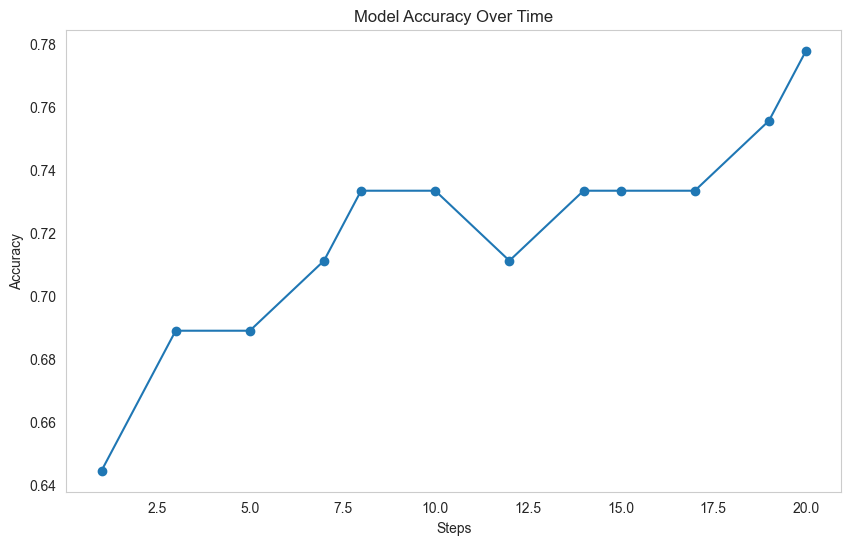

In [18]:
import matplotlib.pyplot as plt

# Retrieve the log history
log_history = trainer.state.log_history

# Extract the accuracy values and the corresponding steps
steps = [entry['step'] for entry in log_history if 'eval_accuracy' in entry]
accuracy_over_steps = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]

# Plot the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(steps, accuracy_over_steps, marker='o')
plt.title('Model Accuracy Over Time')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [15]:
ds["test"]

Dataset({
    features: ['idx', 'source', 'task_text', 'image', 'label'],
    num_rows: 45
})

In [6]:

# Load the images and crop them around the orange bounding box
# Path: image_classification.ipynb


params = {}
params['image_ids'] = data_labels['image_id']
#params['image_ids'] = np.array(['347ED694-833B-4F44-ABD9-8A26E9BF12A7_1_201_a.jpeg'])
params['images_folder'] = images_folder
params['cropped_images_folder'] = cropped_images_folder
params['hsv_range'] = [[8, 120, 200], [12, 255, 255]] #filter for a specific color (tested for 100% capture of 150 examples
params['kernal'] = np.ones((20,20), np.uint8)
params['min_bb_area'] = 1
params['max_bb_area'] = 1000000000
params['min_ratio'] = 1.0

image, cropped_image, mask = crop_images_by_box(params)

6241326
6241326
5575350
5944356
5825034
5698746
4832988
4222290
4222290
4222290
4222290
4830840
5472909
5472909
5472909
5472909
5472909
5472909
5472909
5472909
5472909
5472909
5472909
5472909
5472909
5472909
5472909
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
6144723
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5905671
5177730
5177730
6373230
6373230
6488742
6488742
6488742
6488742
6488742
6488742
6488742
6488742
6488742
6488742
6488742
6488742
6488742
6488742


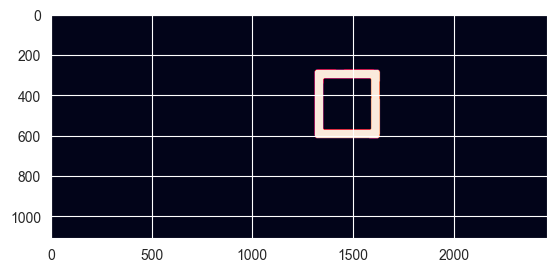

In [8]:
plt.imshow(mask)

In [9]:
data_labels

,row_number,image_id,address,ac_present,ac_leaking,ac_discolored,comments,num_ac,black1hot,white1hot,present1hot,leaking1hot,present_unknown1hot,leaking_unknown1hot,color_unknown1hot
0,1,347ED694-833B-4F44-ABD9-8A26E9BF12A7_1_201_a.jpeg,"1330 W Willow St, Lafayette, LA 70506, USA",yes,yes,blackwhite,NaN,4.0,1,1,1,1,1,1,1
1,2,56E8920C-C46B-4CC9-96CC-178AE00230D3.jpeg,"1110 N University Ave, Lafayette, LA 70506, USA",yes,unknown,unknown,"There is a black tone in all the roof parcel, ...",3.0,0,0,1,0,1,0,0
2,3,0AD2D165-CE95-4F5C-BF88-524EA08A686E.jpeg,"106 Madeline Ave, Lafayette, LA 70501, USA",no,no,no,NaN,0.0,0,0,0,0,0,0,0
3,4,66B175F8-4DAC-4FBA-B8F5-C26711B0C71F.jpeg,"200 S Bienville St, Lafayette, LA 70501, USA",yes,yes,black,NaN,2.0,1,0,1,1,1,1,1
4,5,55CE2555-D78E-49BE-8E89-476C586FEAE1.jpeg,"100 W St Louis St, Lafayette, LA 70506, USA",no,no,no,NaN,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,B1C7EC79-8557-4E99-B35F-84D865173443.jpeg,"2541 E Thomas Ave, Fresno, CA 93701, USA",yes,no,no,NaN,5.0,0,0,1,0,1,0,0
146,147,BE4A6D79-5A14-426D-BE3B-AB1E723C6D1B.jpeg,"520 W Riordan Rd, Flagstaff, AZ 86001, United ...",no,no,no,NaN,0.0,0,0,0,0,0,0,0
147,148,95EACEFD-27BD-4C6C-91EE-9F2FC2C55F21.jpeg,"2025 E White Ave, Fresno, CA 93701, USA",yes,yes,blackwhite,NaN,5.0,1,1,1,1,1,1,1
148,149,118B1765-3890-4C35-92B8-6570017F9193.jpeg,"510 W Tucson Ave, Flagstaff, AZ 86001, USA",no,no,no,NaN,0.0,0,0,0,0,0,0,0


In [10]:
    
## Step 2: Building the model
# Path: image_classification.ipynb


NameError: name 'processor' is not defined

In [67]:
# Define the transformations
# Use the same transformations as the MobileNetV2 model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

# Create the dataset
dataset = ACDataset(data_labels, cropped_images_folder, transform=transform)

In [68]:
# Split the dataset into training, testing, and validation sets

train_size = 0.6
test_size = 0.1
val_size = 0.3
num_samples = len(dataset)

indices = np.arange(num_samples)
train_indices, test_val_indices = train_test_split(indices, test_size=test_size+val_size, random_state=random_seed)
test_val_indices = np.array(test_val_indices)
test_indices, val_indices = train_test_split(test_val_indices, test_size=val_size/(test_size+val_size), random_state=random_seed)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)


In [69]:
len(train_dataset)

90

In [70]:
# Define the dataloaders
batch_size = 15
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [71]:
# Load the pretrained MobileNetV2 model from torchvision
model_folder = '../data/models/'
model = mobilenet_v2()
checkpoint = torch.load(model_folder + 'mobilenet_v2-b0353104.pth')

# Load the weights from the checkpoint into the model
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [85]:
# Retrain the model from the last layer
model.classifier[1] = nn.Linear(1280, 1)


In [113]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

In [114]:
# Train the model to predict whether or not an air conditioner is present (just present1hot and no other features)
num_epochs = 100
device = torch.device('mps')
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, present1hot, present_unknown1hot, leaking1hot, leaking_unknown1hot in tqdm(train_dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        present1hot = present1hot.to(device).float()
        present1hot = present1hot.view(outputs.shape)
        loss = criterion(outputs, present1hot)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}')

    model.eval()
    val_loss = 0.0
    for images, present1hot, present_unknown1hot, leaking1hot, leaking_unknown1hot in tqdm(val_dataloader):
        images = images.to(device)
        outputs = model(images)
        present1hot = present1hot.to(device).float()
        present1hot = present1hot.view(outputs.shape)
        loss = criterion(outputs, present1hot)
        val_loss += loss.item()

    val_losses.append(val_loss / len(val_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_losses[-1]}')

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 1/100, Train Loss: 0.08717715600505471


100%|██████████| 3/3 [00:00<00:00, 11.19it/s]


Epoch 1/100, Validation Loss: 1.7678736050923665


100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


Epoch 2/100, Train Loss: 0.14068877200285593


100%|██████████| 3/3 [00:00<00:00, 13.54it/s]


Epoch 2/100, Validation Loss: 2.1983396212259927


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


Epoch 3/100, Train Loss: 0.059885102634628616


100%|██████████| 3/3 [00:00<00:00, 13.75it/s]


Epoch 3/100, Validation Loss: 1.441213568051656


100%|██████████| 6/6 [00:00<00:00,  6.71it/s]


Epoch 4/100, Train Loss: 0.029776686647286017


100%|██████████| 3/3 [00:00<00:00, 14.02it/s]


Epoch 4/100, Validation Loss: 1.2743894855181377


100%|██████████| 6/6 [00:00<00:00,  6.61it/s]


Epoch 5/100, Train Loss: 0.1011720778575788


100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


Epoch 5/100, Validation Loss: 0.8754984537760416


100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


Epoch 6/100, Train Loss: 0.03946515964344144


100%|██████████| 3/3 [00:00<00:00, 14.31it/s]


Epoch 6/100, Validation Loss: 1.0861137708028157


100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


Epoch 7/100, Train Loss: 0.021286385599523783


100%|██████████| 3/3 [00:00<00:00, 10.03it/s]


Epoch 7/100, Validation Loss: 1.1207116444905598


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


Epoch 8/100, Train Loss: 0.07095019709474097


100%|██████████| 3/3 [00:00<00:00, 14.64it/s]


Epoch 8/100, Validation Loss: 1.2586524685223897


100%|██████████| 6/6 [00:00<00:00,  6.63it/s]


Epoch 9/100, Train Loss: 0.012231440477383634


100%|██████████| 3/3 [00:00<00:00, 14.72it/s]


Epoch 9/100, Validation Loss: 1.0674041708310444


100%|██████████| 6/6 [00:00<00:00,  6.92it/s]


Epoch 10/100, Train Loss: 0.024961249553598464


100%|██████████| 3/3 [00:00<00:00, 14.59it/s]


Epoch 10/100, Validation Loss: 0.7596888939539591


100%|██████████| 6/6 [00:00<00:00,  7.00it/s]


Epoch 11/100, Train Loss: 0.027295089268591255


100%|██████████| 3/3 [00:00<00:00, 14.42it/s]


Epoch 11/100, Validation Loss: 1.4237348635991414


100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


Epoch 12/100, Train Loss: 0.01691694064841916


100%|██████████| 3/3 [00:00<00:00, 11.81it/s]


Epoch 12/100, Validation Loss: 1.192293405532837


100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


Epoch 13/100, Train Loss: 0.005215846622983615


100%|██████████| 3/3 [00:00<00:00, 13.16it/s]


Epoch 13/100, Validation Loss: 0.8578772942225138


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


Epoch 14/100, Train Loss: 0.011983486959555497


100%|██████████| 3/3 [00:00<00:00, 13.10it/s]


Epoch 14/100, Validation Loss: 1.0351234475771587


100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


Epoch 15/100, Train Loss: 0.003908639288662623


100%|██████████| 3/3 [00:00<00:00, 12.24it/s]


Epoch 15/100, Validation Loss: 0.8674407203992208


100%|██████████| 6/6 [00:00<00:00,  6.92it/s]


Epoch 16/100, Train Loss: 0.014383930480107665


100%|██████████| 3/3 [00:00<00:00, 14.84it/s]


Epoch 16/100, Validation Loss: 1.2509605089823406


100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


Epoch 17/100, Train Loss: 0.006602193699412358


100%|██████████| 3/3 [00:00<00:00, 11.44it/s]


Epoch 17/100, Validation Loss: 1.4668485522270203


100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


Epoch 18/100, Train Loss: 0.006893925019539893


100%|██████████| 3/3 [00:00<00:00, 14.70it/s]


Epoch 18/100, Validation Loss: 1.403574287891388


100%|██████████| 6/6 [00:00<00:00,  6.85it/s]


Epoch 19/100, Train Loss: 0.03484300835407339


100%|██████████| 3/3 [00:00<00:00, 14.86it/s]


Epoch 19/100, Validation Loss: 2.21069864432017


100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


Epoch 20/100, Train Loss: 0.010944253338190416


100%|██████████| 3/3 [00:00<00:00, 14.07it/s]


Epoch 20/100, Validation Loss: 3.0176730950673423


100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


Epoch 21/100, Train Loss: 0.02502899632478754


100%|██████████| 3/3 [00:00<00:00, 10.94it/s]


Epoch 21/100, Validation Loss: 2.2827994426091514


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


Epoch 22/100, Train Loss: 0.03747645082573096


100%|██████████| 3/3 [00:00<00:00, 14.16it/s]


Epoch 22/100, Validation Loss: 2.1608965396881104


100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


Epoch 23/100, Train Loss: 0.07311087544076145


100%|██████████| 3/3 [00:00<00:00, 11.76it/s]


Epoch 23/100, Validation Loss: 2.5657585064570108


100%|██████████| 6/6 [00:00<00:00,  6.68it/s]


Epoch 24/100, Train Loss: 0.024458617631656427


100%|██████████| 3/3 [00:00<00:00, 14.65it/s]


Epoch 24/100, Validation Loss: 2.415062109629313


100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 25/100, Train Loss: 0.08386371059653659


100%|██████████| 3/3 [00:00<00:00, 15.18it/s]


Epoch 25/100, Validation Loss: 2.410024404525757


100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


Epoch 26/100, Train Loss: 0.1220692852512002


100%|██████████| 3/3 [00:00<00:00, 14.01it/s]


Epoch 26/100, Validation Loss: 4.247914950052897


100%|██████████| 6/6 [00:00<00:00,  6.68it/s]


Epoch 27/100, Train Loss: 0.2107919758806626


100%|██████████| 3/3 [00:00<00:00, 14.73it/s]


Epoch 27/100, Validation Loss: 1.8413857221603394


100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


Epoch 28/100, Train Loss: 0.25991503793435794


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


Epoch 28/100, Validation Loss: 1.845088521639506


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


Epoch 29/100, Train Loss: 0.07563048166533311


100%|██████████| 3/3 [00:00<00:00, 13.02it/s]


Epoch 29/100, Validation Loss: 2.2108923196792603


100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


Epoch 30/100, Train Loss: 0.08142280112951994


100%|██████████| 3/3 [00:00<00:00, 13.16it/s]


Epoch 30/100, Validation Loss: 1.4986538688341777


100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


Epoch 31/100, Train Loss: 0.043931176885962486


100%|██████████| 3/3 [00:00<00:00, 14.70it/s]


Epoch 31/100, Validation Loss: 1.1924687226613362


100%|██████████| 6/6 [00:00<00:00,  6.92it/s]


Epoch 32/100, Train Loss: 0.047748148324899375


100%|██████████| 3/3 [00:00<00:00, 13.21it/s]


Epoch 32/100, Validation Loss: 1.0893345673878987


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


Epoch 33/100, Train Loss: 0.011927132766383389


100%|██████████| 3/3 [00:00<00:00, 14.79it/s]


Epoch 33/100, Validation Loss: 1.2949885527292888


100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


Epoch 34/100, Train Loss: 0.05726843699812889


100%|██████████| 3/3 [00:00<00:00, 13.91it/s]


Epoch 34/100, Validation Loss: 1.4377804001172383


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Epoch 35/100, Train Loss: 0.024379897008960445


100%|██████████| 3/3 [00:00<00:00, 11.54it/s]


Epoch 35/100, Validation Loss: 1.8142258127530415


100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


Epoch 36/100, Train Loss: 0.007527889800257981


100%|██████████| 3/3 [00:00<00:00, 13.09it/s]


Epoch 36/100, Validation Loss: 1.1099411149819691


100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


Epoch 37/100, Train Loss: 0.007435453085539241


100%|██████████| 3/3 [00:00<00:00, 14.46it/s]


Epoch 37/100, Validation Loss: 0.8854346573352814


100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


Epoch 38/100, Train Loss: 0.030568381111758452


100%|██████████| 3/3 [00:00<00:00, 14.78it/s]


Epoch 38/100, Validation Loss: 1.1640868584314983


100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


Epoch 39/100, Train Loss: 0.05374022883673509


100%|██████████| 3/3 [00:00<00:00, 13.12it/s]


Epoch 39/100, Validation Loss: 0.8908089995384216


100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


Epoch 40/100, Train Loss: 0.013593191824232539


100%|██████████| 3/3 [00:00<00:00, 11.81it/s]


Epoch 40/100, Validation Loss: 0.8206390937169393


100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


Epoch 41/100, Train Loss: 0.016082153073512018


100%|██████████| 3/3 [00:00<00:00, 12.07it/s]


Epoch 41/100, Validation Loss: 0.6497198541959127


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


Epoch 42/100, Train Loss: 0.01319496762395526


100%|██████████| 3/3 [00:00<00:00, 14.80it/s]


Epoch 42/100, Validation Loss: 0.6082414786020914


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


Epoch 43/100, Train Loss: 0.049305316216001906


100%|██████████| 3/3 [00:00<00:00, 12.36it/s]


Epoch 43/100, Validation Loss: 1.2230398853619893


100%|██████████| 6/6 [00:00<00:00,  6.79it/s]


Epoch 44/100, Train Loss: 0.02584727657570814


100%|██████████| 3/3 [00:00<00:00, 12.88it/s]


Epoch 44/100, Validation Loss: 1.8245230118433635


100%|██████████| 6/6 [00:00<00:00,  6.78it/s]


Epoch 45/100, Train Loss: 0.009771396891058734


100%|██████████| 3/3 [00:00<00:00, 14.29it/s]


Epoch 45/100, Validation Loss: 1.6743112206459045


100%|██████████| 6/6 [00:00<00:00,  6.92it/s]


Epoch 46/100, Train Loss: 0.04415633882551143


100%|██████████| 3/3 [00:00<00:00, 13.60it/s]


Epoch 46/100, Validation Loss: 1.0254639238119125


100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


Epoch 47/100, Train Loss: 0.11928267125040293


100%|██████████| 3/3 [00:00<00:00, 13.41it/s]


Epoch 47/100, Validation Loss: 1.458883802096049


100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


Epoch 48/100, Train Loss: 0.145082486482958


100%|██████████| 3/3 [00:00<00:00, 14.20it/s]


Epoch 48/100, Validation Loss: 2.45476496219635


100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


Epoch 49/100, Train Loss: 0.03964749708150824


100%|██████████| 3/3 [00:00<00:00, 13.74it/s]


Epoch 49/100, Validation Loss: 3.4229848384857178


100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


Epoch 50/100, Train Loss: 0.027137623944630224


100%|██████████| 3/3 [00:00<00:00, 12.24it/s]


Epoch 50/100, Validation Loss: 2.0196606715520224


100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


Epoch 51/100, Train Loss: 0.0216696341522038


100%|██████████| 3/3 [00:00<00:00, 11.12it/s]


Epoch 51/100, Validation Loss: 1.3903039544820786


100%|██████████| 6/6 [00:00<00:00,  6.80it/s]


Epoch 52/100, Train Loss: 0.01817919733002782


100%|██████████| 3/3 [00:00<00:00, 13.98it/s]


Epoch 52/100, Validation Loss: 1.2717722455660503


100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 53/100, Train Loss: 0.05409631369790683


100%|██████████| 3/3 [00:00<00:00, 14.36it/s]


Epoch 53/100, Validation Loss: 1.38537202278773


100%|██████████| 6/6 [00:00<00:00,  6.49it/s]


Epoch 54/100, Train Loss: 0.006581676580632727


100%|██████████| 3/3 [00:00<00:00, 13.24it/s]


Epoch 54/100, Validation Loss: 1.3279787302017212


100%|██████████| 6/6 [00:00<00:00,  6.49it/s]


Epoch 55/100, Train Loss: 0.05164764914661646


100%|██████████| 3/3 [00:00<00:00, 10.97it/s]


Epoch 55/100, Validation Loss: 1.2825961510340373


100%|██████████| 6/6 [00:00<00:00,  6.77it/s]


Epoch 56/100, Train Loss: 0.012406821770127863


100%|██████████| 3/3 [00:00<00:00, 14.21it/s]


Epoch 56/100, Validation Loss: 1.1911114652951558


100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


Epoch 57/100, Train Loss: 0.00904380485493069


100%|██████████| 3/3 [00:00<00:00, 14.61it/s]


Epoch 57/100, Validation Loss: 1.0714582602183025


100%|██████████| 6/6 [00:00<00:00,  6.90it/s]


Epoch 58/100, Train Loss: 0.0038035048831564686


100%|██████████| 3/3 [00:00<00:00, 13.78it/s]


Epoch 58/100, Validation Loss: 1.1158220966657002


100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


Epoch 59/100, Train Loss: 0.048208190593868494


100%|██████████| 3/3 [00:00<00:00, 13.87it/s]


Epoch 59/100, Validation Loss: 1.1463704506556194


100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


Epoch 60/100, Train Loss: 0.006581683623759697


100%|██████████| 3/3 [00:00<00:00, 13.07it/s]


Epoch 60/100, Validation Loss: 1.4514539241790771


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


Epoch 61/100, Train Loss: 0.01732645610657831


100%|██████████| 3/3 [00:00<00:00, 12.32it/s]


Epoch 61/100, Validation Loss: 1.4335106213887532


100%|██████████| 6/6 [00:00<00:00,  6.78it/s]


Epoch 62/100, Train Loss: 0.019387765632321436


100%|██████████| 3/3 [00:00<00:00, 13.59it/s]


Epoch 62/100, Validation Loss: 1.2503658731778462


100%|██████████| 6/6 [00:00<00:00,  6.89it/s]


Epoch 63/100, Train Loss: 0.002975589712150395


100%|██████████| 3/3 [00:00<00:00, 13.45it/s]


Epoch 63/100, Validation Loss: 1.1988987922668457


100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


Epoch 64/100, Train Loss: 0.03284387030483534


100%|██████████| 3/3 [00:00<00:00, 12.28it/s]


Epoch 64/100, Validation Loss: 1.0004533330599468


100%|██████████| 6/6 [00:00<00:00,  6.69it/s]


Epoch 65/100, Train Loss: 0.009519467518354455


100%|██████████| 3/3 [00:00<00:00, 13.70it/s]


Epoch 65/100, Validation Loss: 1.1482751766840618


100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


Epoch 66/100, Train Loss: 0.0731408914240698


100%|██████████| 3/3 [00:00<00:00, 12.20it/s]


Epoch 66/100, Validation Loss: 1.450264851252238


100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 67/100, Train Loss: 0.0730617274530232


100%|██████████| 3/3 [00:00<00:00, 13.90it/s]


Epoch 67/100, Validation Loss: 1.9418340921401978


100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


Epoch 68/100, Train Loss: 0.0129712408912989


100%|██████████| 3/3 [00:00<00:00, 14.12it/s]


Epoch 68/100, Validation Loss: 1.8669850826263428


100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 69/100, Train Loss: 0.05090613973637422


100%|██████████| 3/3 [00:00<00:00, 11.73it/s]


Epoch 69/100, Validation Loss: 2.5635399421056113


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


Epoch 70/100, Train Loss: 0.038673770148307085


100%|██████████| 3/3 [00:00<00:00, 12.98it/s]


Epoch 70/100, Validation Loss: 2.316759983698527


100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


Epoch 71/100, Train Loss: 0.0650106935063377


100%|██████████| 3/3 [00:00<00:00, 13.98it/s]


Epoch 71/100, Validation Loss: 1.6315614183743794


100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


Epoch 72/100, Train Loss: 0.02980399182221542


100%|██████████| 3/3 [00:00<00:00, 14.41it/s]


Epoch 72/100, Validation Loss: 1.6928521792093914


100%|██████████| 6/6 [00:00<00:00,  6.89it/s]


Epoch 73/100, Train Loss: 0.004891611926723272


100%|██████████| 3/3 [00:00<00:00, 14.31it/s]


Epoch 73/100, Validation Loss: 1.6913061141967773


100%|██████████| 6/6 [00:00<00:00,  6.80it/s]


Epoch 74/100, Train Loss: 0.02341495069170681


100%|██████████| 3/3 [00:00<00:00, 13.52it/s]


Epoch 74/100, Validation Loss: 1.2641579310099285


100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


Epoch 75/100, Train Loss: 0.022920913218210142


100%|██████████| 3/3 [00:00<00:00, 14.57it/s]


Epoch 75/100, Validation Loss: 1.1923244794209797


100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


Epoch 76/100, Train Loss: 0.010992552493310844


100%|██████████| 3/3 [00:00<00:00, 13.23it/s]


Epoch 76/100, Validation Loss: 1.519609769185384


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


Epoch 77/100, Train Loss: 0.006227342955147226


100%|██████████| 3/3 [00:00<00:00, 13.81it/s]


Epoch 77/100, Validation Loss: 1.2073646187782288


100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


Epoch 78/100, Train Loss: 0.041720240017942466


100%|██████████| 3/3 [00:00<00:00, 13.49it/s]


Epoch 78/100, Validation Loss: 1.351885994275411


100%|██████████| 6/6 [00:00<00:00,  7.03it/s]


Epoch 79/100, Train Loss: 0.033176156769817076


100%|██████████| 3/3 [00:00<00:00, 13.12it/s]


Epoch 79/100, Validation Loss: 1.6140828529993694


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


Epoch 80/100, Train Loss: 0.034743422254299126


100%|██████████| 3/3 [00:00<00:00, 11.06it/s]


Epoch 80/100, Validation Loss: 1.5011194547017415


100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


Epoch 81/100, Train Loss: 0.04574852293202033


100%|██████████| 3/3 [00:00<00:00, 14.61it/s]


Epoch 81/100, Validation Loss: 1.811100920041402


100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


Epoch 82/100, Train Loss: 0.11705000248427193


100%|██████████| 3/3 [00:00<00:00, 14.34it/s]


Epoch 82/100, Validation Loss: 1.779445211092631


100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


Epoch 83/100, Train Loss: 0.0956950803908209


100%|██████████| 3/3 [00:00<00:00, 13.18it/s]


Epoch 83/100, Validation Loss: 1.508464018503825


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


Epoch 84/100, Train Loss: 0.043930806374798216


100%|██████████| 3/3 [00:00<00:00, 14.01it/s]


Epoch 84/100, Validation Loss: 1.8356635769208272


100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 85/100, Train Loss: 0.05489244180110594


100%|██████████| 3/3 [00:00<00:00, 13.42it/s]


Epoch 85/100, Validation Loss: 1.4174770315488179


100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


Epoch 86/100, Train Loss: 0.018385115390022595


100%|██████████| 3/3 [00:00<00:00, 13.81it/s]


Epoch 86/100, Validation Loss: 1.32226358850797


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


Epoch 87/100, Train Loss: 0.040978592820465565


100%|██████████| 3/3 [00:00<00:00, 14.93it/s]


Epoch 87/100, Validation Loss: 1.3601757287979126


100%|██████████| 6/6 [00:00<00:00,  6.76it/s]


Epoch 88/100, Train Loss: 0.013168429800619682


100%|██████████| 3/3 [00:00<00:00, 11.26it/s]


Epoch 88/100, Validation Loss: 1.2519991199175518


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


Epoch 89/100, Train Loss: 0.02224953620073696


100%|██████████| 3/3 [00:00<00:00, 12.42it/s]


Epoch 89/100, Validation Loss: 1.1294831434885662


100%|██████████| 6/6 [00:00<00:00,  6.78it/s]


Epoch 90/100, Train Loss: 0.006515436165500432


100%|██████████| 3/3 [00:00<00:00, 13.95it/s]


Epoch 90/100, Validation Loss: 1.1603231032689412


100%|██████████| 6/6 [00:00<00:00,  7.00it/s]


Epoch 91/100, Train Loss: 0.007670638694738348


100%|██████████| 3/3 [00:00<00:00, 14.73it/s]


Epoch 91/100, Validation Loss: 1.3292608459790547


100%|██████████| 6/6 [00:00<00:00,  6.91it/s]


Epoch 92/100, Train Loss: 0.04766910084678481


100%|██████████| 3/3 [00:00<00:00, 14.41it/s]


Epoch 92/100, Validation Loss: 1.6480751236279805


100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


Epoch 93/100, Train Loss: 0.0059432098641991615


100%|██████████| 3/3 [00:00<00:00, 14.07it/s]


Epoch 93/100, Validation Loss: 1.9030948479970295


100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


Epoch 94/100, Train Loss: 0.08954749828747784


100%|██████████| 3/3 [00:00<00:00, 13.48it/s]


Epoch 94/100, Validation Loss: 1.5304719905058544


100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


Epoch 95/100, Train Loss: 0.004915099319381018


100%|██████████| 3/3 [00:00<00:00, 13.72it/s]


Epoch 95/100, Validation Loss: 2.0499998331069946


100%|██████████| 6/6 [00:00<00:00,  6.43it/s]


Epoch 96/100, Train Loss: 0.012760865424449245


100%|██████████| 3/3 [00:00<00:00, 12.68it/s]


Epoch 96/100, Validation Loss: 1.7342596054077148


100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


Epoch 97/100, Train Loss: 0.05454876219543318


100%|██████████| 3/3 [00:00<00:00, 11.68it/s]


Epoch 97/100, Validation Loss: 1.3947280248006184


100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


Epoch 98/100, Train Loss: 0.005645635984061907


100%|██████████| 3/3 [00:00<00:00, 14.29it/s]


Epoch 98/100, Validation Loss: 1.4554575284322102


100%|██████████| 6/6 [00:00<00:00,  6.76it/s]


Epoch 99/100, Train Loss: 0.01824835695636769


100%|██████████| 3/3 [00:00<00:00, 14.33it/s]


Epoch 99/100, Validation Loss: 1.4241555134455364


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


Epoch 100/100, Train Loss: 0.01622513964927445


100%|██████████| 3/3 [00:00<00:00, 14.13it/s]

Epoch 100/100, Validation Loss: 1.5306874712308247


In [103]:
outputs.shape

torch.Size([15, 1])

In [110]:
len(tqdm(train_dataloader))

  0%|          | 0/6 [00:00<?, ?it/s]


6

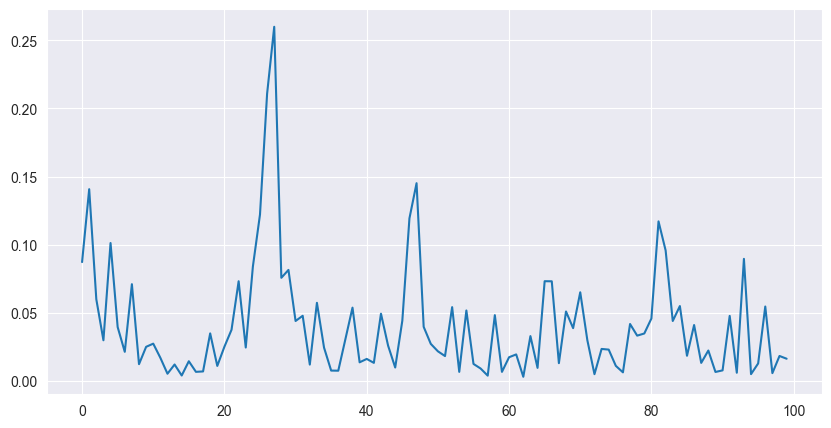

In [117]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')

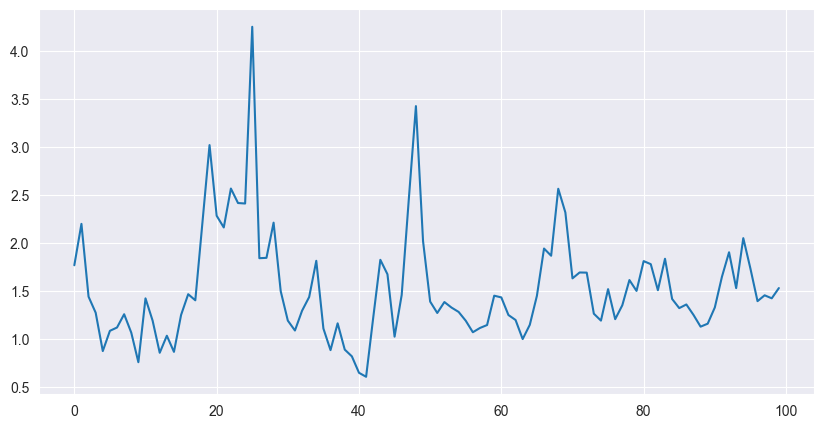

In [118]:
plt.figure(figsize=(10,5))
plt.plot(val_losses, label='Validation Loss')

In [286]:
# Train the model
num_epochs = 9
device = torch.device('mps')
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()



train_loss = 0.0
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# In your training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, present1hot, present_unknown1hot, leaking1hot, leaking_unknown1hot in tqdm(train_dataloader):
        images = images.to(device)
        labels = torch.stack((present1hot, present_unknown1hot, leaking1hot, leaking_unknown1hot), dim=1).to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        images = images.to(device)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}')

    model.eval()
    val_loss = 0.0
    for images, present1hot, present_unknown1hot, leaking1hot, leaking_unknown1hot in tqdm(val_dataloader):
        images = images.to(device)
        labels = torch.stack((present1hot, present_unknown1hot, leaking1hot, leaking_unknown1hot), dim=1).to(device)
    
        outputs = model(images)
        labels = torch.stack((present1hot, present_unknown1hot, leaking1hot, leaking_unknown1hot), dim=1).to(device).float()
    
        loss = criterion(outputs, labels)
        val_loss += loss.item()
    
        outputs = model(images)
        val_losses.append(val_loss / len(val_dataloader))
        loss = criterion(outputs, labels)
        val_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_losses[-1]}')
    val_losses.append(val_loss / len(val_dataloader))


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 1/9, Train Loss: 0.6445513963699341


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Epoch 1/9, Validation Loss: 0.8453575372695923


100%|██████████| 8/8 [00:01<00:00,  6.80it/s]


Epoch 2/9, Train Loss: 0.3586892671883106


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


Epoch 2/9, Validation Loss: 0.5811765193939209


100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Epoch 3/9, Train Loss: 0.274941960349679


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


Epoch 3/9, Validation Loss: 1.0836135149002075


100%|██████████| 8/8 [00:01<00:00,  7.05it/s]


Epoch 4/9, Train Loss: 0.17311180476099253


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


Epoch 4/9, Validation Loss: 2.92637300491333


100%|██████████| 8/8 [00:01<00:00,  6.28it/s]


Epoch 5/9, Train Loss: 0.1394012151286006


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Epoch 5/9, Validation Loss: 1.6315103769302368


100%|██████████| 8/8 [00:01<00:00,  7.19it/s]


Epoch 6/9, Train Loss: 0.11275029741227627


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Epoch 6/9, Validation Loss: 1.9561128616333008


100%|██████████| 8/8 [00:01<00:00,  7.20it/s]


Epoch 7/9, Train Loss: 0.12614407180808485


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Epoch 7/9, Validation Loss: 0.958021342754364


100%|██████████| 8/8 [00:01<00:00,  7.05it/s]


Epoch 8/9, Train Loss: 0.11548375454731286


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Epoch 8/9, Validation Loss: 1.281532645225525


100%|██████████| 8/8 [00:01<00:00,  7.24it/s]


Epoch 9/9, Train Loss: 0.13812619401142


100%|██████████| 1/1 [00:00<00:00, 11.23it/s]

Epoch 9/9, Validation Loss: 1.4685406684875488


In [320]:
val_loss

1.3904805183410645

In [ ]:
# Evaluate the model
model.eval()
y_true = []
y_pred = []

for images, ac_present, ac_leaking, num_ac, ac_discolored in tqdm(test_dataloader):
    images = images.to(device)
    ac_present = ac_present.to(device)
    ac_leaking = ac_leaking.to(device)
    num_ac = num_ac.to(device)
    ac_discol

In [231]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_impl',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_per

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, ac_present, ac_leaking, num_ac, ac_discolored in tqdm(train_dataloader):
        images = images.to(device)
        ac_present = ac_present.to(device)
        ac_leaking = ac_leaking.to(device)
        num_ac = num_ac.to(device)
        ac_discolored = ac_discolored.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ac_present)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}')

    model.eval()
    val_loss = 0.0
    for images, ac_present, ac_leaking, num_ac, ac_discolored in tqdm(val_dataloader):
        images = images.to(device)
        ac_present = ac_present.to(device)
        ac_leaking = ac_leaking.to(device)
        num_ac = num_ac.to(device)
        ac_discolored = ac_discolored.to(device)

        outputs = model(images)
        loss = criterion(outputs, ac_present)
        val_loss += loss.item()

    val_losses.append(val_loss / len(val_dataloader))
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_losses[-1]}')

In [ ]:
# Evaluate the model
model.eval()
y_true = []
y_pred = []

for images